In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch

import argparse
import json
import os

import numpy as np
import torch

import models
from datasets.kg_dataset import KGDataset
from utils.train import avg_both, format_metrics

from matplotlib import pyplot as plt
import torch.nn.functional as F

In [2]:
def test(model_dir):
    # load config
    with open(os.path.join(model_dir, "config.json"), "r") as f:
        config = json.load(f)
    args = argparse.Namespace(**config)

    # create dataset
    dataset_path = os.path.join("/home/liuruizhou/paper_code/DVKGE_old/data", args.dataset)
    dataset = KGDataset(dataset_path, False)
    test_examples = dataset.get_examples("test")
    filters = dataset.get_filters()

    # load pretrained model weights
    model = getattr(models, args.model)(args)
    device = 'cuda'
    model.to(device)
    model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
    model.set_eval_hyper_dist_n_space_idx(None)

    # eval
    test_metrics = avg_both(*model.compute_metrics(test_examples, filters))
    return test_metrics, model, test_examples, filters


In [3]:
model_dir = "/home/liuruizhou/paper_code/DVKGE_GL_v10/logs/DVKGE_01_21_51"
test_metrics, model, test_examples, filters = test(model_dir)
print(format_metrics(test_metrics, split='test'))

eval_hyper_dist_n_space_idx is set from None to None


/home/liuruizhou/paper_code/DVKGE_GL_v10/utils/pmath.py:888: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:402.)
  res = torch.where(cond, res_0, res_c)


	 test MR: 2203.88 | MRR: 0.502 | H@1: 0.458 | H@3: 0.516 | H@10: 0.587


array([[1.82248639e-03, 6.04874596e-04, 4.06117724e-04, 4.76782778e-04,
        6.94660561e-04, 8.91994486e-04, 1.02027579e-03],
       [6.15438575e-04, 1.19095864e+00, 2.53925540e-03, 7.86738359e-04,
        3.02995477e-01, 2.61466469e-04, 1.93243278e-04],
       [1.01219839e-03, 9.10987278e-04, 3.63719537e-03, 4.52158664e-04,
        1.61931581e-03, 1.55174940e-03, 1.18136791e-03],
       [5.33950975e-02, 1.87532122e-02, 2.19796934e-03, 7.27034756e-04,
        5.76460573e-03, 8.11653546e-02, 3.60098584e-01],
       [6.39518251e-02, 1.03880685e-04, 1.52469866e-01, 5.36134432e-02,
        1.23470727e-03, 2.63522201e-01, 6.60464951e-01],
       [2.05649489e-03, 3.25858631e-03, 1.17761854e-03, 7.68354937e-04,
        1.07221517e-03, 1.71402401e-03, 2.23518350e-03],
       [6.91518143e-03, 1.01631012e+00, 2.69060454e-03, 1.48123462e-04,
        7.58223571e-01, 2.69501434e-03, 4.67339487e-04],
       [2.35740742e-03, 2.80740380e-03, 7.98217178e-04, 9.94377447e-04,
        1.11254976e-03, 9

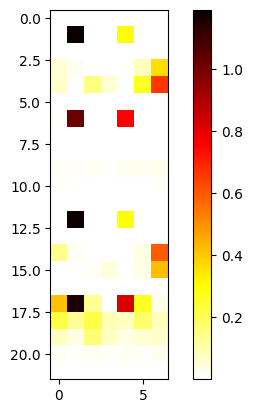

In [6]:
data = (F.softplus(model.c_local.weight)).detach().cpu().numpy()
im = plt.imshow(data, cmap=plt.cm.hot_r)
plt.colorbar(im)
data

In [21]:
mrr_mat = np.zeros((2 * (test_examples[:, 1].max()+1), model.n_space))
mean_mrr_mat = np.zeros(((test_examples[:, 1].max()+1), model.n_space))
for space_i in range(model.n_space): 
    model.set_eval_hyper_dist_n_space_idx(space_i)
    for rel_i in test_examples[:, 1].unique():
        rel_i_test_examples = test_examples[test_examples[:, 1] == rel_i]
        mean_rank, mean_reciprocal_rank, hits_at = model.compute_metrics(rel_i_test_examples.cuda(), filters)
        mrr_mat[rel_i, space_i] = mean_reciprocal_rank['rhs']
        mrr_mat[rel_i + test_examples[:, 1].max()+1, space_i] = mean_reciprocal_rank['lhs']
        mean_mrr_mat[rel_i, space_i] = avg_both(mean_rank, mean_reciprocal_rank, hits_at)['MRR']
        # print(f"rel id: {rel_i} | num: {rel_i_test_examples.shape[0]} | MRR: {test_metrics['MRR']}")


eval_hyper_dist_n_space_idx is set from 11 to 0
eval_hyper_dist_n_space_idx is set from 0 to 1
eval_hyper_dist_n_space_idx is set from 1 to 2
eval_hyper_dist_n_space_idx is set from 2 to 3
eval_hyper_dist_n_space_idx is set from 3 to 4
eval_hyper_dist_n_space_idx is set from 4 to 5
eval_hyper_dist_n_space_idx is set from 5 to 6
eval_hyper_dist_n_space_idx is set from 6 to 7
eval_hyper_dist_n_space_idx is set from 7 to 8
eval_hyper_dist_n_space_idx is set from 8 to 9
eval_hyper_dist_n_space_idx is set from 9 to 10
eval_hyper_dist_n_space_idx is set from 10 to 11


(22, 12)

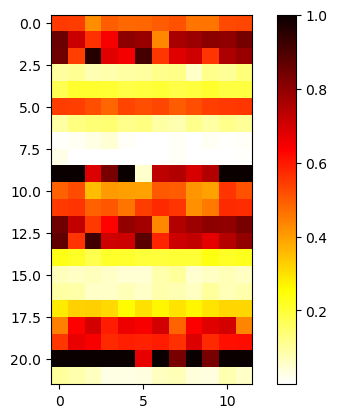

In [20]:
im = plt.imshow(mrr_mat, cmap=plt.cm.hot_r)
plt.colorbar(im)
mrr_mat.shape

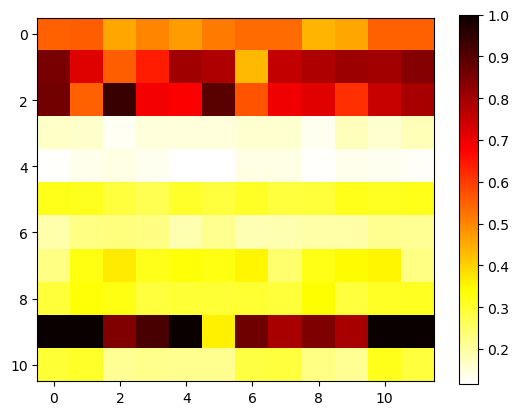

In [22]:
im = plt.imshow(mean_mrr_mat, cmap=plt.cm.hot_r)
plt.colorbar(im)

In [35]:
ahht_mrr = np.array([[0.59861934],
       [0.84503204],
       [0.73100039],
       [0.15683475],
       [0.17747983],
       [0.31732733],
       [0.21184498],
       [0.35361298],
       [0.3341423 ],
       [1.        ],
       [0.35964276]])
((mean_mrr_mat - ahht_mrr) >= 0)[10]

array([False, False, False, False, False, False, False, False, False,
       False, False, False])